## N-WAVE Tutorial 1: regression

Tutorial written by Marco Rasetto and Giuseppe Gentile.
This tutorial aim to show main differences between snntorch library and the Neuronova's N-WAVE simulator for a simple regression task.

For reference, we approach the same problem shown in snntorch documentation: https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_regression_1.html

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

Fix the seeds for reproducibility.

In [2]:
# Seed
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

Generate the dataset in the same way of the snntorch's linked tutorial. 

In [3]:
class RegressionDataset(torch.utils.data.Dataset):
    """Simple regression dataset."""

    def __init__(self, timesteps, num_samples, mode):
        """Linear relation between input and output"""
        self.num_samples = num_samples  # number of generated samples
        feature_lst = []  # store each generated sample in a list

        # generate linear functions one by one
        for idx in range(num_samples):
            end = float(torch.rand(1))  # random final point
            lin_vec = torch.linspace(
                start=0.0, end=end, steps=timesteps
            )  # generate linear function from 0 to end
            feature = lin_vec.view(timesteps, 1)
            feature_lst.append(feature)  # add sample to list

        self.features = torch.stack(feature_lst, dim=1)  # convert list to tensor

        # option to generate linear function or square-root function
        if mode == "linear":
            self.labels = self.features * 1

        elif mode == "sqrt":
            slope = float(torch.rand(1))
            self.labels = torch.sqrt(self.features * slope)

        else:
            raise NotImplementedError("'linear', 'sqrt'")

    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        return self.features[:, idx, :], self.labels[:, idx, :]

We show a random sample of the dataset here:

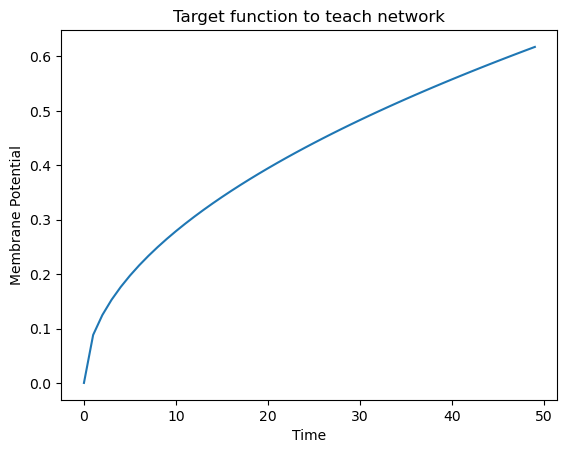

In [4]:
num_steps = 50
num_samples = 1
mode = "sqrt"  # 'linear' or 'sqrt'

# generate a single data sample
dataset = RegressionDataset(timesteps=num_steps, num_samples=num_samples, mode=mode)

# plot
sample = dataset.labels[:, 0, 0]
plt.plot(sample)
plt.title("Target function to teach network")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.show()

## Data handling representation of N-WAVE simulator
In traditional machine learning (ML) or deep learning (DL) approaches, time-series data is often represented in a format of [B, T, N], where:
* B is the batch size (number of samples processed in parallel),
* T is the number of time steps (sequence length),
* N is the number of features (dimensions of each time step).

However, in Spiking Neural Networks (SNN), the representation is typically [T, B, N]. This format is used in libraries like snntorch because the training process and learning methods in SNNs differ from those in traditional DL models like LSTMs or Transformers. The [T, B, N] format is specifically chosen to align with the temporal dynamics of how spiking neurons are processed during training.

On the other hand, N-WAVE, aims to keep the data format consistent with that of traditional DL models. Therefore, the simulator expects the data in the [B, T, N] format, aligning with standard deep learning practices.

As we see, the generated dataset is in format [T, B, N], hence, before passing it through the N-WAVE simulator we need to permute the dimensions.

In [5]:
dataset.labels.shape

torch.Size([50, 1, 1])

Create dataloader to serve data in batches.

In [6]:
batch_size = 1  # only one sample to learn
dataloader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=batch_size, drop_last=True
)

# Simulate a chip
#### Define the structure of the chip

We use a chip with a single layer, with the simplest leaky integrate-and-fire neurons without recurrence.

In [7]:
from Neuronova_Sim.NeuronovaSim import NeuronovaSim

We want to fit a single dimensional function, so input size is 1, as well as output_size.

In [8]:
input_size = 1
output_size = 1

Now we have to define the structure of the chip, that is, how many layers and how many neurons per layer. In this case, we keep it simple, using a single hidden layer with 128 neurons.

In [9]:
neurons_per_layer = [128, output_size]

Generate the chip!
Since is a single layer, we use as chip topology a string that represent the layer's topology, that is, fully connected ("FF"). Other possible option is recurrent ("RC").

We use "LIF" as chip model, since we can use one neuron's type per chip, and not a neuron type per layers. 

taus and threshold can be either scalars or lists/tensors. In this case, being a single layer, we use the same tau for all neurons of that layer. But we can pass a list of taus (1D) shaped as the layers's length, so that all neurons in that layer uses the same tau, or use a 2D tensor so to map each tau to each neuron of each layer.

dt instead is the time discretization, that is common for the chip's layer.

In [10]:
device="cpu"
model = NeuronovaSim(
    chip_topology="FF",
    chip_model="LIF",
    input_size=input_size,
    neuron_number_per_layer=neurons_per_layer,
    taus=62.7e-3,
    thresholds=1.0,
    dt=1e-3,
    device=device,
    learn_taus=True,
)

In [11]:
train_batch = iter(dataloader)
with torch.no_grad():
    for feature, label in train_batch:
        print(feature.shape)
        print(label.shape)
        feature = feature.to(device)
        label = label.to(device)
        mem = model(feature)[3]

torch.Size([1, 50, 1])
torch.Size([1, 50, 1])


In [12]:
print(mem.shape)
print(label.shape)

torch.Size([1, 50, 1])
torch.Size([1, 50, 1])


Let’s observe the behavior of the output neuron before it has been trained and how it compares to the target function.
We do this also to show a main difference with the snntorch tutorial, highlighted with comments in the for loop.

In N-WAVE we can pass directly the data in [B,T,N], avoiding the swap axes before.


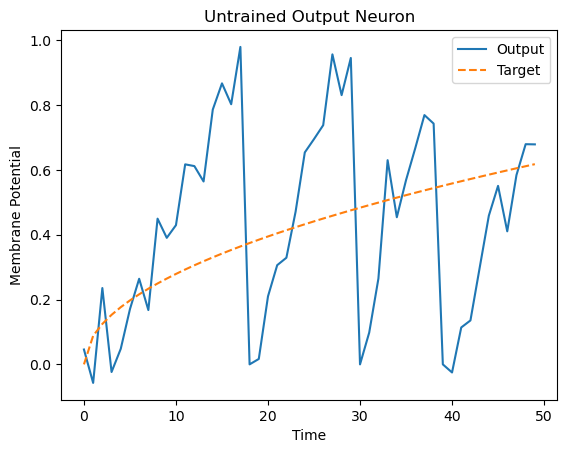

In [13]:
train_batch = iter(dataloader)

# run a single forward-pass
with torch.no_grad():
    for feature, label in train_batch:
        ##################################################################################################################################
        ##################################################################################################################################
        ##################################################################################################################################
                                                    # feature = torch.swapaxes(input=feature, axis0=0, axis1=1) 
                                                    # label = torch.swapaxes(input=label, axis0=0, axis1=1)
        ##################################################################################################################################
        ##################################################################################################################################
        ##################################################################################################################################
        feature = feature.to(device)
        label = label.to(device)
        spk0, spk1, mem0, mem1, _, _ = model(feature)

# plot over time (: in time direction)
plt.plot(mem1[0, :, 0].cpu(), label="Output")
plt.plot(label[0, :, 0].cpu(), "--", label="Target")
plt.title("Untrained Output Neuron")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.legend(loc="best")
plt.show()

## Train the chip
We return all the layers output for now. Future release will returns only the last membrane output and give the choice to the user if wants to store all the training history.

In [14]:
num_iter = 5000  # train for 100 iterations
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

loss_hist = []  # record loss

# training loop
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        train_batch = iter(dataloader)
        minibatch_counter = 0
        loss_epoch = []

        for feature, label in train_batch:

            # forward pass
            spk0, spk1, mem0, mem1, _, _ = model(feature)
            loss_val = loss_function(mem1, label)

            optimizer.zero_grad()  # zero out gradients
            loss_val.backward()  # calculate gradients
            optimizer.step()  # update weights

            # store loss
            loss_hist.append(loss_val.item())
            loss_epoch.append(loss_val.item())
            minibatch_counter += 1

            avg_batch_loss = (
                sum(loss_epoch) / minibatch_counter
            )  # calculate average loss p/epoch
            pbar.set_postfix(loss="%.3e" % avg_batch_loss)  # print loss p/batch

100%|██████████| 5000/5000 [00:30<00:00, 161.62it/s, loss=3.206e-04]


Evaluate the chip

In [15]:
loss_function = torch.nn.L1Loss()  # Use L1 loss instead

# pause gradient calculation during evaluation
with torch.no_grad():
    model.eval()

    test_batch = iter(dataloader)
    minibatch_counter = 0
    rel_err_lst = []

    # loop over data samples
    for feature, label in test_batch:

        feature = feature.to(device)
        label = label.to(device)

        # forward-pass
        mem = model(feature)[3] # is the same to get directly the out membrane potential

        # calculate relative error
        rel_err = torch.linalg.norm((mem - label), dim=-1) / torch.linalg.norm(
            label, dim=-1
        )
        rel_err = torch.mean(rel_err[1:, :])

        # calculate loss
        loss_val = loss_function(mem, label)

        # store loss
        loss_hist.append(loss_val.item())
        rel_err_lst.append(rel_err.item())
        minibatch_counter += 1

    mean_L1 = statistics.mean(loss_hist)
    mean_rel = statistics.mean(rel_err_lst)

print(f"{'Mean L1-loss:':<{20}}{mean_L1:1.2e}")

Mean L1-loss:       1.34e-03


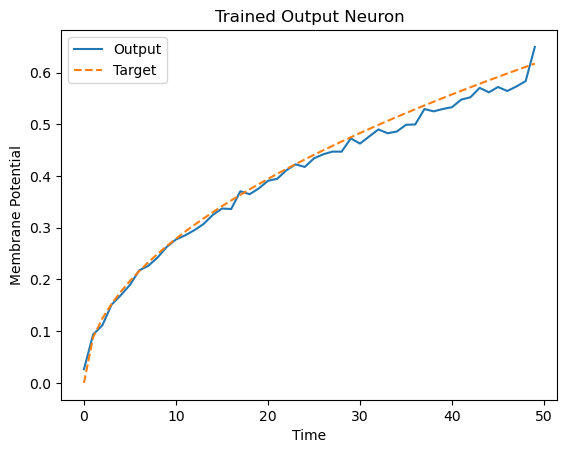

In [16]:
mem = mem.cpu()

label = label.cpu()
plt.title("Trained Output Neuron")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")

for i in range(batch_size):
    # pick a single output neuron, say neuron 0
    out_trace = mem[i, :, 0].cpu()
    target_trace = label[i, :, 0].cpu()

    plt.plot(out_trace, label="Output" if i == 0 else None)
    plt.plot(target_trace, "--", label="Target" if i == 0 else None)

# only label the first iteration to avoid duplicate legend entries
plt.legend(loc="best")
plt.show()

# Simulate a more custom chip

We use a chip with multiple layers, and specifying differnt taus & thresholds for each neurons.
We use a more deep network with fewer neurons per layer, to demonstrate the freedom of choice in the simulator.

In [24]:
device="cpu"
neurons_per_layer = [4,4,2,1]
taus = [[1., 0.9, 1., 0.8], [1., 1., 1., 1.], 0.6, 0.9]
threshold = [1., 1., 1.1, 1]
model = NeuronovaSim(
    chip_topology="FF",
    chip_model="LIF",
    input_size=input_size,
    neuron_number_per_layer=neurons_per_layer,
    taus=taus,
    thresholds=threshold,
    dt=1e-3,
    device=device,
    learn_taus=True,
)

In [26]:
num_iter = 1000  # train for 500 iterations
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

loss_hist = []  # record loss

# training loop
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        train_batch = iter(dataloader)
        minibatch_counter = 0
        loss_epoch = []

        for feature, label in train_batch:

            # forward pass
            mem = model(feature)[7]
            loss_val = loss_function(mem, label)

            optimizer.zero_grad()  # zero out gradients
            loss_val.backward()  # calculate gradients
            optimizer.step()  # update weights

            # store loss
            loss_hist.append(loss_val.item())
            loss_epoch.append(loss_val.item())
            minibatch_counter += 1

            avg_batch_loss = (
                sum(loss_epoch) / minibatch_counter
            )  # calculate average loss p/epoch
            pbar.set_postfix(loss="%.3e" % avg_batch_loss)  # print loss p/batch

100%|██████████| 1000/1000 [00:10<00:00, 92.77it/s, loss=5.340e-03]


In [27]:
loss_function = torch.nn.L1Loss()  # Use L1 loss instead

# pause gradient calculation during evaluation
with torch.no_grad():
    model.eval()

    test_batch = iter(dataloader)
    minibatch_counter = 0
    rel_err_lst = []

    # loop over data samples
    for feature, label in test_batch:

        feature = feature.to(device)
        label = label.to(device)

        # forward-pass
        mem = model(feature)[7]

        # calculate relative error
        rel_err = torch.linalg.norm((mem - label), dim=-1) / torch.linalg.norm(
            label, dim=-1
        )
        rel_err = torch.mean(rel_err[1:, :])

        # calculate loss
        loss_val = loss_function(mem, label)

        # store loss
        loss_hist.append(loss_val.item())
        rel_err_lst.append(rel_err.item())
        minibatch_counter += 1

    mean_L1 = statistics.mean(loss_hist)
    mean_rel = statistics.mean(rel_err_lst)

print(f"{'Mean L1-loss:':<{20}}{mean_L1:1.2e}")

Mean L1-loss:       4.63e-02


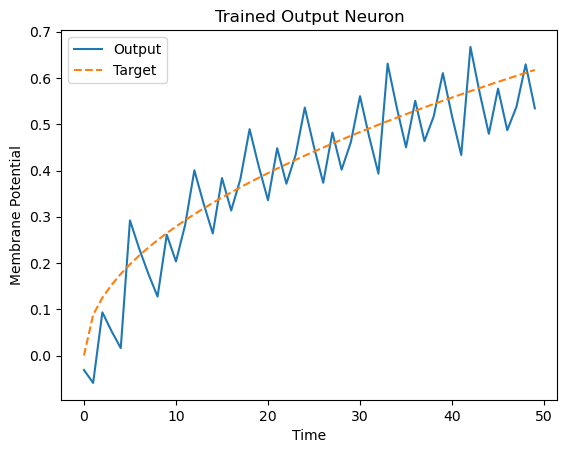

In [28]:
mem = mem.cpu()

label = label.cpu()
plt.title("Trained Output Neuron")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")

for i in range(batch_size):
    # pick a single output neuron, say neuron 0
    out_trace = mem[i, :, 0].cpu()
    target_trace = label[i, :, 0].cpu()

    plt.plot(out_trace, label="Output" if i == 0 else None)
    plt.plot(target_trace, "--", label="Target" if i == 0 else None)

# only label the first iteration to avoid duplicate legend entries
plt.legend(loc="best")
plt.show()